# QCompress: Quantum Autoencoder Simulation Tool

We built QCompress, a framework for the quantum autoencoder (QAE), as our project at Rigetti Computing's first [quantum computing hackathon](https://rigetticomputing.github.io/blog/2018/04/09/Quantum-Hackathon-Recap.html). The main objective of QCompress is to train the quantum autoencoder to compress a quantum data set (i.e. a set of quantum states), expressing the data using fewer qubits.

### What is a quantum autoencoder (QAE)?

<img src="images/qae_image.png" width="400">

Similar to the idea of classical autoencoders, a quantum autoencoder is a function whose parameters are optimized across a training data such that given an $(n+k)$-qubit input $x$, the autoencoder attempts to reproduce $x$. Part of the process involves expressing the input data set using a fewer number of qubits (using $n$ qubits out of $n+k$). This means that if the QAE is successfully trained, the corresponding circuit represents a compressed encoding of the input $x$, which may be useful to applications such as dimension reduction of quantum data. For a more in-depth explanation of the QAE, please refer to the original [paper](https://arxiv.org/abs/1612.02806). In addition, we note that this is one possible realization of a "quantum" autoencoder and that there are other proposed models for the quantum autoencoder.

### Demo Outline
We break up the demo into several parts:
1. Preparation of the quantum data
2. Choosing a programmable circuit
3. Setting up the QAE engine/simulator
4. Running the engine

### Demo Details

For this demo, we try to compress ground states of molecular hydrogen at various bond lengths. We start with 4 qubits and try to compress the information to 1 qubit (i.e. 4-1-4 quantum autoencoder).

<img src="images/qae_setup.png" width="400">

We note that our setup is different from what was proposed in the original [paper](https://arxiv.org/abs/1612.02806). As shown in the figure above, we use 7 total qubits for the 4-1-4 autoencoder, using the last 3 qubits (qubits $q_6$, $q_5$, and $q_4$) as refresh qubits. The unitary $S$ represents the state preparation circuit, gates implemented to produce the input data set. The unitary $U$ represents the training circuit that will be responsible for representing the data set using a fewer number of qubits, in this case using a single qubit. The tilde symbol above the daggered operations indicates that the qubit indexing has been adjusted such that $q_0 \rightarrow q_6$, $q_1 \rightarrow q_5$, $q_2 \rightarrow q_4$, and $q_3 \rightarrow q_3$ (For clarity, refer to the figure below for an equivalent circuit with the refresh qubits moved around). So qubit $q_3$ is to be the "latent space qubit," or qubit to hold the compressed information. Using the circuit structure above (applying  $S$ and $U$ then effectively __un__-applying $S$ and $U$), we train the autoencoder by propagating the QAE circuit with proposed parameters and counting the number of times the measurements of the refresh qubits and the latent space qubits ($q_3$ to $q_6$) are 0000. We negate this value for casting as a minimization problem and average over the training set to compute a single loss value.

<img src="images/qae_adjusted.png" width="400">


In [1]:
# Import modules
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os

from openfermion.hamiltonians import MolecularData
from openfermion.transforms import get_sparse_operator, jordan_wigner
from openfermion.utils import get_ground_state

from forestopenfermion import qubitop_to_pyquilpauli

import pyquil.api as api
from pyquil.gates import *
from pyquil.quil import Program

from grove.alpha.arbitrary_state import arbitrary_state

from qae_engine import *

global pi
pi = np.pi

## Settings

Here we define settings for the QVM (to run our simulations) and for the autoencoder.

In [2]:
# QVM settings
n_samples = 3000                 # number of circuit runs
gate_noise = None                # noise parameter for QVM
measurement_noise = None         # noise parameter for QVM

# Autoencoder settings
n_qubits_in = 4                  # Number of qubits to encode input data
n_qubits_ls = 1                  # Number of qubits in latent space

# Total number of qubits involved in QAE setup
n_total_qubits = n_qubits_in + (n_qubits_in - n_qubits_ls)

# Adjusted qubit indexing for latter half of the QAE setup
new_range = range(n_total_qubits - n_qubits_in, n_total_qubits)
new_range = new_range[::-1]

for qubit_i, qubit_i_new in enumerate(new_range):
    print("{0} -> {1}".format(qubit_i, qubit_i_new))

0 -> 6
1 -> 5
2 -> 4
3 -> 3


# Generating input data

We use routines from `OpenFermion`, `ForestOpenFermion`, and `grove` to generate the input data set. We've provided the data files for you, which were produced using `OpenFermion`'s plugin `OpenFermion-Psi4`.

In [3]:
qvm = api.QVMConnection()

# MolecularData settings
molecule_name = "H2"
basis = "sto-3g"
multiplicity = "singlet"
dist_list = np.arange(0.2, 4.2, 0.1)

# Lists to store HF and FCI energies
hf_energies = []
fci_energies = []
test_energies = []

# Lists to store state preparation circuits
list_SP_circuits = []
list_SP_circuits_dag = []


for dist in dist_list:
    # Fetch file path
    dist = "{0:.1f}".format(dist)
    file_path = os.path.join("H2_sto3g/{0}_{1}_{2}_{3}.hdf5".format(molecule_name,
                                                                    basis,
                                                                    multiplicity,
                                                                    dist))
    
    # Extract molecular info
    molecule = MolecularData(filename=file_path)
    n_qubits = molecule.n_qubits
    hf_energies.append(molecule.hf_energy)
    fci_energies.append(molecule.fci_energy)
    molecular_ham = molecule.get_molecular_hamiltonian()
    
    # Set up hamiltonian in qubit basis
    qubit_ham = jordan_wigner(molecular_ham)

    # Convert from OpenFermion's to PyQuil's data type (QubitOperator to PauliTerm/PauliSum)
    qubit_ham_pyquil = qubitop_to_pyquilpauli(qubit_ham)

    # Sanity check: Obtain ground state energy and check with MolecularData's FCI energy
    molecular_ham_sparse = get_sparse_operator(operator=molecular_ham,
                                               n_qubits=n_qubits)
    ground_energy, ground_state = get_ground_state(molecular_ham_sparse)
    assert np.isclose(molecule.fci_energy, ground_energy)
    
    # Generate unitary to prepare ground states
    state_prep_unitary = arbitrary_state.create_arbitrary_state(
                            ground_state,
                            qubits=range(n_qubits))
    
    # Generate daggered state prep unitary (WITH NEW/ADJUSTED INDICES!)
    state_prep_unitary_dag = arbitrary_state.create_arbitrary_state(
                                ground_state,
                                qubits=new_range).dagger()
    
    # Sanity check: Compute energy wrt wavefunction evolved under state_prep_unitary
    wfn = qvm.wavefunction(state_prep_unitary)
    ket = wfn.amplitudes
    bra = np.transpose(np.conjugate(wfn.amplitudes))
    ham_matrix = molecular_ham_sparse.toarray()
    energy_expectation = np.dot(bra, np.dot(ham_matrix, ket))
    test_energies.append(energy_expectation)
    
    # Store circuits
    list_SP_circuits.append(state_prep_unitary)
    list_SP_circuits_dag.append(state_prep_unitary_dag)

### Try plotting the energies of the input data set.

To (visually) check our state preparation circuits, we run these circuits and plot the energies. The "test" energies overlay nicely with the FCI energies.

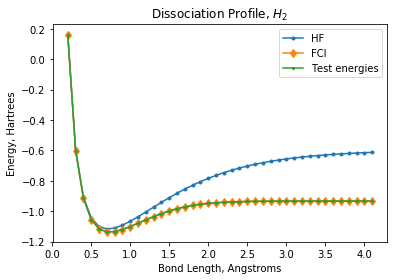

In [4]:
imag_components = np.array([E.imag for E in test_energies])
assert np.isclose(imag_components, np.zeros(len(imag_components))).all()
test_energies = [E.real for E in test_energies]

plt.plot(dist_list, hf_energies, '.-', label='HF')
plt.plot(dist_list, fci_energies, 'd-', markersize=6, label='FCI')
plt.plot(dist_list, test_energies, '.-', markersize=4, label='Test energies')
plt.title("Dissociation Profile, $H_2$")
plt.xlabel("Bond Length, Angstroms")
plt.ylabel("Energy, Hartrees")
plt.legend()
plt.show()

## Training circuit for QAE

Now we want to choose a parametrized circuit which we hope to train to compress the input quantum data set. As part of this project, we created a class called `QAECircuit` that allows us to create such programmable circuits by layer!

However, for this demonstration, we will use a simple 2-parameter circuit, as shown below.

__NOTE__: For more general data sets (and general circuits), we may need to run multiple instances of the QAE with different initial guesses to find a good compression circuit.

In [ ]:
def simple_programmable_circuit(theta, circuit, qubit_indices):
    """Returns parametrized training circuit.
    
    Args:
    =====
    theta : list or numpy.array, required
        List or array of parameters
    circuit : pyquil.quil.Program, required
        Quantum circuit to append variational circuit
    qubit_indices : list, required
        List of qubit indices
        
    Returns:
    ========
    circuit : pyquil.quil.Program
        Quantum circuit with variational circuit added
    """
    if circuit is None:
        circuit = Program()
    else:
        circuit = circuit

    circuit += Program(RX(theta[0], qubit_indices[2]),
                       RX(theta[1], qubit_indices[3]))
    circuit += Program(CNOT(qubit_indices[2], qubit_indices[0]),
                       CNOT(qubit_indices[3], qubit_indices[1]),
                       CNOT(qubit_indices[3], qubit_indices[2]))
    return circuit

## Initialize the QAE engine

Here we create an instance of the quantum_autoencoder class. Leveraging the features of the `Forest` platform, this quantum autoencoder "engine" allows you to run a noisy version of the QVM to get a sense of how the autoencoder performs under noise (but qvm is noiseless in this demo).

In [ ]:
qae = quantum_autoencoder(n_qubits_in=n_qubits_in,
                          n_qubits_latent_space=n_qubits_ls,
                          state_preparation_circuits=list_SP_circuits,
                          state_preparation_circuits_dag=list_SP_circuits_dag,
                          training_circuit=simple_programmable_circuit,                        
                          n_samples=n_samples,
                          gate_noise=gate_noise,
                          meas_noise=measurement_noise,
                          print_interval=1,
                          display_progress=False)

Let's split the data set into training and test set. If we don't input the argument `train_indices`, the data set will be randomly split. However, knowing our quantum data set, we may want to choose various regions along the PES (the energy curve shown above) to train the entire function. Here, we pick 6 out of 40 data points for our training set.

In [ ]:
qae.train_test_split(train_indices=[3, 10, 15, 20, 30, 35])

## Training

The autoencoder is trained in the cell below, where the default optimization algorithm is Constrained Optimization BY Linear Approximation (COBYLA). The lowest possible mean loss value is -1.000.

In [ ]:
initial_guess = [pi/2., 0.]

avg_loss_train = qae.train(initial_guess)

/anaconda2/envs/py37/lib/python3.7/site-packages/pyquil/gates.py:487: UserWarning: Indexing measurement addresses by integers is deprecated. Replacing this with the MemoryReference ro[i] instead.
  warn("Indexing measurement addresses by integers is deprecated. " +
/anaconda2/envs/py37/lib/python3.7/site-packages/pyquil/quil.py:867: UserWarning: Please DECLARE all memory. I'm adding a declaration for the `ro` register, but I won't do this for you in the future.
  warnings.warn("Please DECLARE all memory. I'm adding a declaration for the `ro` register, "


Iter    0 Mean Loss: -0.0000000
Iter    1 Mean Loss: -0.0000000
Iter    2 Mean Loss: -0.0007778


### Plot training losses

In [ ]:
import seaborn as sns

with plt.xkcd():
    fig = plt.figure(figsize=(8, 6))
    plt.plot(qae.train_history, 'o-', linewidth=1)
    #plt.title("Training Loss", fontsize=16)
    plt.xlabel("Function Evaluation",fontsize=20)
    plt.ylabel("Loss Value", fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    #plt.show()

    plt.savefig('example_loss.png')

#np.save('loss_history', qae.train_history)

## Testing

Now test with the rest of the data set, and check the mean loss for the testing set!

In [ ]:
avg_loss_test = qae.predict()

In [ ]:
# Optimized parameters
print(qae.optimized_params)